## Task 3.1

Consider the same situation of tasks 1.1 and 1.2 in assignment 1, but modify the $u_t$’s so to be 10 uniformly spaced values in $[−1, 1]$, and set $\alpha = 0$ so that we have Laplacian noises (more precisely, with scale $\beta = 1$). Use as the "true model" a quartic.

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.font_manager import FontProperties as FP
import math

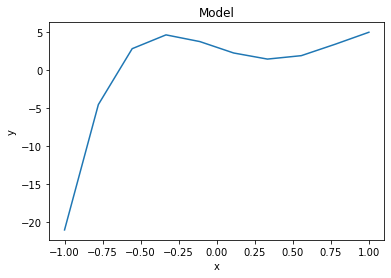

In [8]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

# params: [theta_0, theta_1, theta_2]
true_params = [3,-7,2, 20, -13]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=-1, stop=1, num=10)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

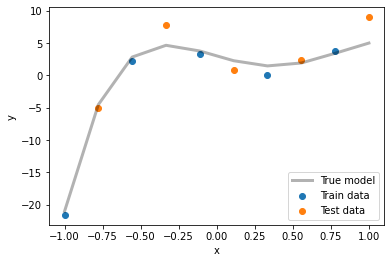

In [13]:
# Generate data points
loc = 0           # location (mean) parameter 
scale = 1         # scaling (std dev) parameter
magnitude = 1   # noise magnitude
N = 10           # number of samples
alpha = 0
beta = 1
normVariance = 1
gamma = 0

range_low, range_high = -1, 1
#u = np.sort(np.random.uniform(range_low,range_high,N))
u = np.linspace(range_low, range_high,N)
train_u = u[::2]
test_u = u[1::2]
y_true = y_model(u)

# Generate noise
from scipy.stats import norm, laplace
pdf = laplace.pdf

noiseLaplace = magnitude * np.random.laplace(loc, beta, int((1-alpha)*N))
noiseGaussian = magnitude * np.random.normal(loc, normVariance, int(alpha*N))

y = y_true + noiseLaplace

train_y = y[::2]
test_y = y[1::2]

# Plot measured data
plt.scatter(train_u, train_y, label=r"Train data")
plt.scatter(test_u, test_y, label=r"Test data")
u0 = np.linspace(-1, max(u), N)
plt.plot(u, y_model(u), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

## Task 3.2

Code again both the LS and ML estimators, but this time add the possibility of testing 10 different model structures, i.e. from order 0 to order 9.

In [16]:
def LS(u, y, model_order, samples):
    # Step 1
    # Matrix form
    u_tensor = np.ones((samples,1))
    if model_order > 0:
        u_tensor_0 = np.reshape(u, (samples,1))
        for i in range(1,model_order+1):
            u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)
    
    # Step 2
    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
    
    if np.linalg.matrix_rank(u_transpose_dot_u) == u_transpose_dot_u.shape[0]:
        u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
    else:
        u_transpose_dot_u_inv = np.linalg.pinv(u_transpose_dot_u)
    
    # Step 3
    u_transpose_dot_y = np.dot(u_tensor.T, y)  # calculating dot product
    
    # Step 4
    LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
    #theta_hat = uTu_inv @ uTy

    # Recreate model based on LS estimate:
    LS_params = LS_params.tolist()
    #LS_model = arbitrary_poly(LS_params)
    
    return LS_params

from scipy.stats import norm, laplace 
pdf = laplace.pdf

def log_lik(par_vec, y, x):
    global pdf  # Use the distribution class chosen earlier
    # If the standard deviation parameter is negative, return a large value:
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

import scipy.optimize as optimize

def ML(u, y, model_order, samples):
    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess verctor has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(model_order+1)
    init_guess[-1] = samples

    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(fun = log_lik,
                                x0 = init_guess,
                                options={'disp': False},
                                args = (y, u))

    MLE_params = opt_res.x[:-1]
    #MLE_model = arbitrary_poly(MLE_params)
    
    return MLE_params

In [17]:
def get_euclidean_dist(estimated, true):
    params_diff = len(estimated) - len(true)
    if params_diff < 0:
        estimated = np.append(estimated, np.zeros(-params_diff))
    elif params_diff > 0:
        true.extend(np.zeros(params_diff))
        
    diff = np.array(true) - estimated
    euclidean_dist = np.linalg.norm(diff)
    return euclidean_dist

def get_estimators(params):
    N = len(params)
    estimators = []
    for i in range(N):
        estimator = arbitrary_poly(params[i])
        estimators.append(estimators)
    return estimators

def get_models(u, y, num_models):
    N = len(u)
    LS_models = []
    ML_models = []
    for i in range(num_models):
        LS_params = LS(u, y, i, N)
        LS_models.append(LS_params)
        ML_params = ML(u, y, i, N)
        ML_models.append(ML_params)
    return LS_models, ML_models

In [19]:
num_models = 10
LS_params, ML_params = get_models(train_u, train_y, num_models)

print(LS_params)
#Recreate model based on LS and ML estimate:
LS_estimators = get_estimators(LS_params)
ML_estimators = get_estimators(ML_params)
estimators = [LS_estimators, ML_estimators]

# Plot configuration
estimator_type = ["LS", "ML"]
model_type = ["Constant", "Affine", "Quadratic", "Cubed", "Quartic", "Quintic", "Sextic", "Septic", "Octic", "Nonic"]
fontP = FP()
fontP.set_size('xx-small')

# PRINTING PARAMETERS
print(f"True model parameters:\t {true_params}")
for j in range(len(LS_params)):
    LS_params_rounded = ["{:.2f}".format(round(i, 2)) for i in LS_params[j].tolist()]
    print(f"LS {model_type[j]} model parameters:\t {LS_params_rounded}")
    ML_params_rounded = ["{:.2f}".format(round(i, 2)) for i in ML_params[j].tolist()]
    print(f"ML {model_type[j]} model parameters:\t {ML_params_rounded}")


# PLOTTING

# Plot true vs measured vs estimated
for i, estimator in enumerate(estimators):
    plt.figure(num=i)   
    plt.plot(u_t, y_model(u_t), "k", alpha=0.5, label="True model")
    plt.scatter(test_u, test_y, alpha=0.5, label="Measures")
    for j, model in enumerate(estimator):
        plt.figure(num=i)
        plt.plot(test_u, model(test_u), alpha=0.5, lw=3, label=f"Model: {model_type[j]}")
        plt.legend(loc='upper right', prop=fontP)
        plt.title(f"{estimator_type[i]} "r"$\hat{y_t}$ vs. measured $y_t$ vs true y")
        plt.xlabel("x")
        plt.ylabel("y")

[[-2.4121538044247295], [-1.198430112541054, 10.923513226953068], [4.95581487783514, 7.350080651895922, -16.080446587757148], [2.8898414828294454, -10.547284376748777, -6.6791069812706, 28.204018819459492], [2.3216160108956956, -9.00543030953827, -0.14382096610347617, 24.576503233947733, -8.16191006740064], [2.519095343157602, -7.521514184255466, -4.036984944982578, 13.912619291800866, -1.3065561045918912, 12.339637133056158], [2.522333589068097, -7.519694681928684, -4.269998292904461, 14.181593607886612, 0.02159183268054221, 11.760437606687177, -1.4067785432170012], [2.5798853936055295, -7.110251632114682, -5.4750759508996225, 12.297608794858775, 1.2421682091718935, 9.023842721760133, 0.7123378413623982, 6.4033035557538085], [2.580462633418776, -7.108806246545441, -5.506759294839867, 12.329274009902178, 1.3532488667161147, 8.9793170749372, 0.846847321467294, 6.321842251850807, -0.3073603836359098], [2.6020559580661597, -6.959999072245864, -5.984872687003872, 11.773757257464695, 1.7785

AttributeError: 'list' object has no attribute 'tolist'

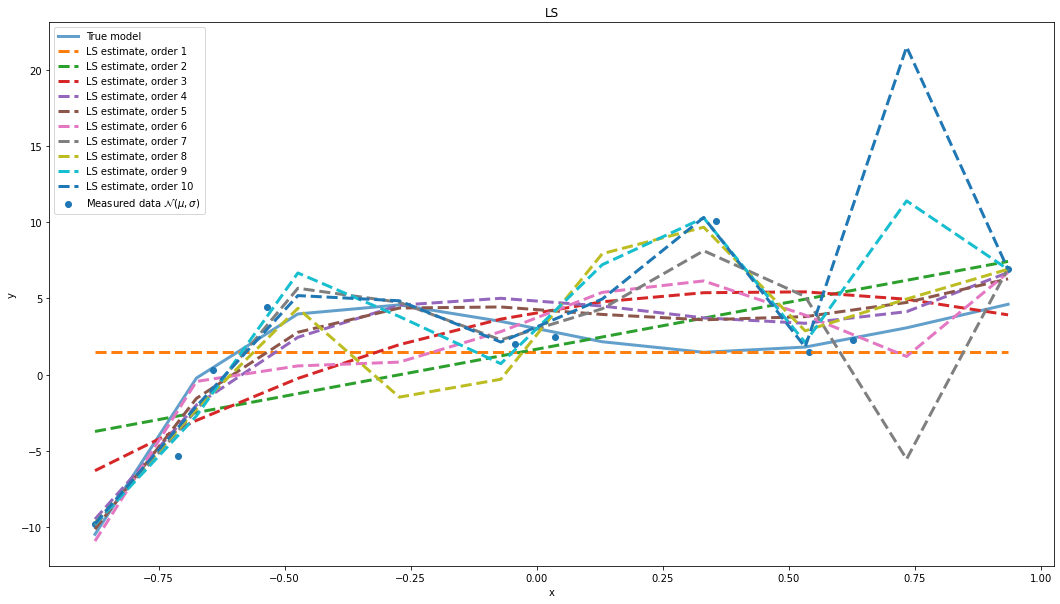

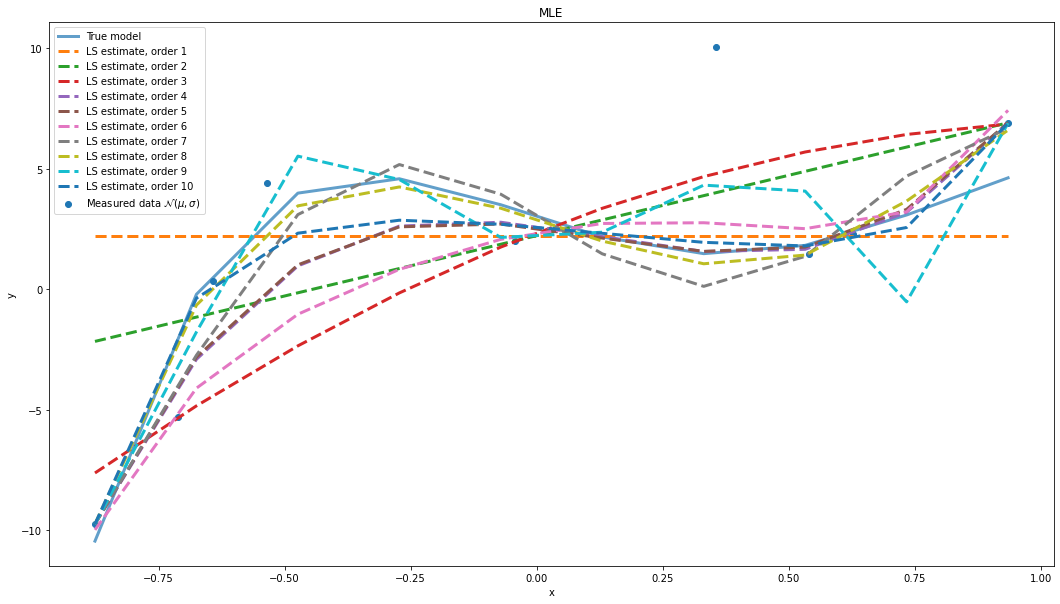

In [20]:
def LSorderFunc(order, u, y, N):
    u_tensor_0 = np.reshape(u, (N,1))
    ones_vec = np.ones((N,1))
    
    u_tensor = ones_vec
    
    for i in range(1,order):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i), axis=1)
        
    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
    u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse

    u_transpose_dot_y = np.dot(u_tensor.T,y)  # calculating dot product

    LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
    LS_params_rounded = ["{:.2f}".format(round(i, 2)) for i in LS_params.tolist()]
    
    LS_params = LS_params.tolist()
    LS_estimate = arbitrary_poly(LS_params)
    return LS_params, LS_estimate


def log_lik(par_vec, y, x):
    if par_vec[-1] < 0:
        return(1e8)
    # The likelihood function values:
    lik = pdf(y,
              loc = sum([p*(x**i) for i, p in enumerate(par_vec[:-1])]),
              scale = par_vec[-1])
    
    #This is similar to calculating the likelihood for Y - XB
    # res = y - par_vec[0] - par_vec[1] * x
    # lik = norm.pdf(res, loc = 0, sd = par_vec[2])
    
    # If all logarithms are zero, return a large value
    if all(v == 0 for v in lik):
        return(1e8)
    # Logarithm of zero = -Inf
    return(-sum(np.log(lik[np.nonzero(lik)])))

def MLEfunction(order,u, y, N):

    import scipy.optimize as optimize

    # The likelihood function includes the scale (std dev) parameter which is also estimated by the optimized
    # therefore the initial guess verctor has length n+2 [theta_0_hat, theta_1_hat, ... , theta_n_hat, sigma_hat]
    init_guess = np.zeros(order+1)
    init_guess[-1] = N

    # Do Maximum Likelihood Estimation:
    opt_res = optimize.minimize(fun = log_lik,
                                x0 = init_guess,
                                options={'disp': False},
                                args = (y, u))

    MLE_params = opt_res.x[:-1]
    MLE_estimate = arbitrary_poly(MLE_params)

    MLE_params_rounded = ["{:.2f}".format(round(i, 2)) for i in MLE_params.tolist()]
    #print(f"\nMLE parameters of order :      {MLE_params_rounded}")

    return MLE_params, MLE_estimate

def plotSeveral(orderArray):
    plt.figure(1, figsize=(18,10))
    plt.scatter(u, y,  label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
    u0 = np.linspace(min(u), max(u), N)
    plt.plot(u0, y_model(u0), alpha=0.7, lw=3, label="True model")
    
    for i in orderArray:
        LS_params, LS_estimate = LSorderFunc(i, u, y, N)
        plt.plot(u0, LS_estimate(u0),linestyle="--",  lw=3, label=r"LS estimate, order " f"{i}")
    plt.title("LS")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y");
    
    plt.figure(2, figsize=(18,10))
    plt.scatter(u, y,  label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
    u0 = np.linspace(min(u), max(u), N)
    plt.plot(u0, y_model(u0), alpha=0.7, lw=3, label="True model")
    
    for i in orderArray:
        MLE_params, MLE_estimate = MLEfunction(i, u, y, N)
        plt.plot(u0, MLE_estimate(u0),linestyle="--",  lw=3, label=r"LS estimate, order " f"{i}")
    
    plt.title("MLE")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y");
    
    
plotSeveral([1,2,3,4,5,6,7,8,9,10])

#LS_params_1, LS_estimate_1 = LSorderFunc(1, u, y, N)
#LS_params_2, LS_estimate_2 = LSorderFunc(2, u, y, N)
#LS_params_3, LS_estimate_3 = LSorderFunc(3, u, y, N)
#print(LS_params_1, LS_params_2, LS_params_3)
# Plot true vs. estimated model

#plt.scatter(u, y,  label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
#u0 = np.linspace(min(u), max(u), N)
#plt.plot(u0, y_model(u0), "g", alpha=0.7, lw=3, label="True model")
#plt.plot(u0, LS_estimate_1(u0), color="darkorange" ,linestyle="--",  lw=3, label="LS estimate, order 1")
#plt.plot(u0, LS_estimate_2(u0), color="black" ,linestyle="--",  lw=3, label="LS estimate, order 2")

#plt.plot(u0, LS_estimate_3(u0), "r--",  lw=3, label="LS estimate, order 3")
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");